# SDSS DATA ANALYSIS: Classification of Stars, Galaxies and Quasars

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States.
This notebook aims to analyze the dataset obtained from 'Sloan Digital Sky Survey' to classify a cluster in space as a 'Star', a 'Galaxy' or a 'Quasar'. 

Note:
This notebook was inspired by Niklas Donges' approach on Titanic classification.

A summary of some important features are:

ra, dec — right ascension and declination respectively

u, g, r, i, z — filter bands (a.k.a. photometric system or astronomical magnitudes)

run, rerun, camcol, field — descriptors of fields (i.e. 2048 x 1489 pixels) within image

redshift — increase in wavelength due to motion of astronomical object

plate — plate number

mjd — modified Julian date of observation

fiberid — optic fiber ID

For further information regarding the different attributes of the SDSS: http://www.sdss3.org/dr8/glossary.php

## 1. Importing the necessary libraries and the Data required

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import svm
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MaxAbsScaler

from sklearn.naive_bayes import GaussianNB

%matplotlib inline

In [102]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [103]:
import xgboost
from xgboost import XGBClassifier

In [104]:
df = pd.read_csv('Skyserver.csv')

## 2. Preliminary Data Analysis

###    2.1 The Data

In [105]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


### 2.2 Coulumns and their Types

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
objid        10000 non-null float64
ra           10000 non-null float64
dec          10000 non-null float64
u            10000 non-null float64
g            10000 non-null float64
r            10000 non-null float64
i            10000 non-null float64
z            10000 non-null float64
run          10000 non-null int64
rerun        10000 non-null int64
camcol       10000 non-null int64
field        10000 non-null int64
specobjid    10000 non-null float64
class        10000 non-null object
redshift     10000 non-null float64
plate        10000 non-null int64
mjd          10000 non-null int64
fiberid      10000 non-null int64
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


### 2.3 Summary Statistics

In [107]:
df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


### 2.4 Missing Values

There are no missing values in the given SDSS dataset. The data is complete!

### 2.5 Filtering Data

In [108]:
df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)

In [109]:
df.head()

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590,3306,54922,512


### 2.6 Correlation Matrix

In [110]:
df.corr()

,ra,dec,u,g,r,i,z,redshift,plate,mjd,fiberid
ra,1.000000,0.003596,0.031238,0.043909,0.047103,0.045731,0.042950,0.030307,-0.095329,-0.086887,0.057485
dec,0.003596,1.000000,0.035279,0.061875,0.063404,0.058292,0.056870,0.067021,0.088342,0.066147,0.155012
u,0.031238,0.035279,1.000000,0.849232,0.692379,0.602630,0.551483,0.163741,-0.129430,-0.168793,0.011301
g,0.043909,0.061875,0.849232,1.000000,0.958106,0.907419,0.879622,0.407576,-0.054981,-0.092772,0.047187
r,0.047103,0.063404,0.692379,0.958106,1.000000,0.977672,0.969197,0.441080,0.019787,-0.009345,0.061081
i,0.045731,0.058292,0.602630,0.907419,0.977672,1.000000,0.981507,0.431450,0.072958,0.050896,0.069977
z,0.042950,0.056870,0.551483,0.879622,0.969197,0.981507,1.000000,0.424034,0.112397,0.095658,0.067980
redshift,0.030307,0.067021,0.163741,0.407576,0.441080,0.431450,0.424034,1.000000,-0.038091,-0.057957,0.046532
plate,-0.095329,0.088342,-0.129430,-0.054981,0.019787,0.072958,0.112397,-0.038091,1.000000,0.966881,0.229811
mjd,-0.086887,0.066147,-0.168793,-0.092772,-0.009345,0.050896,0.095658,-0.057957,0.966881,1.000000,0.190328


In [111]:
def corr_plt(df):
    corr= df.corr()
    fig, ax =plt.subplots(figsize=(8,8))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)),corr.columns)
    plt.yticks(range(len(corr.columns)),corr.columns)
    plt.show()

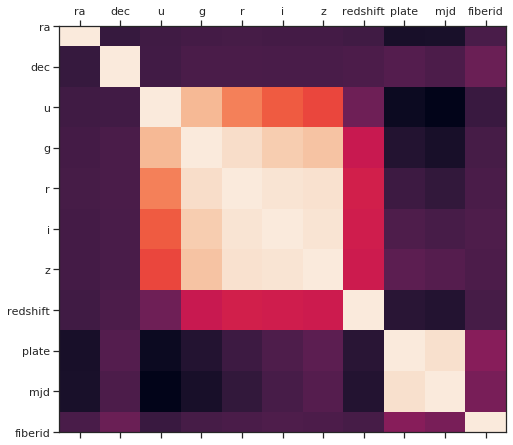

In [112]:
corr_plt(df)

## 3. Exploratory Data Analysis

### 3.1 'Class' Count

In [113]:
occ = df['class'].value_counts().to_frame().rename(index=str, columns={'class': 'Occurrences'})
occ

,Occurrences
GALAXY,4998
STAR,4152
QSO,850


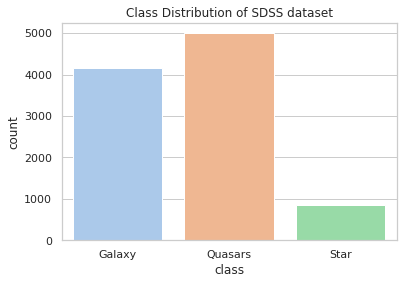

In [114]:
sns.set(style="whitegrid")
sns.set_palette("pastel")

bp = sns.countplot(x=df["class"])
plt.title("Class Distribution of SDSS dataset")
bp.set_xticklabels(["Galaxy","Quasars","Star"])
plt.show()

### 3.2 Distribution of Redshift values for different 'Class' Values

#### 3.2.1 Redshift Distribution of Class - Star

Text(0.5, 1.0, 'Star')

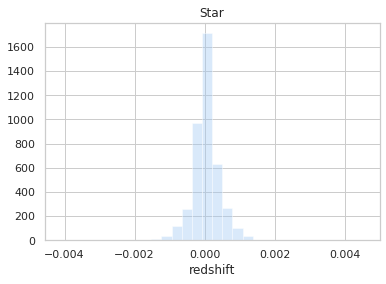

In [115]:
ax = sns.distplot(df[df['class']=='STAR'].redshift, bins = 30, kde = False)
ax.set_title('Star')

#### 3.2.2 Redshift Distribution of Class - Galaxy

Text(0.5, 1.0, 'GALAXY')

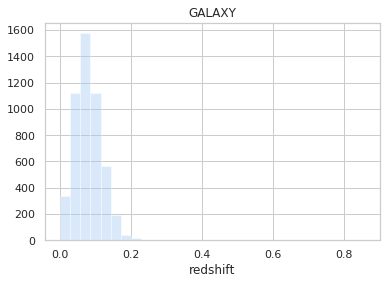

In [116]:
ax = sns.distplot(df[df['class']=='GALAXY'].redshift, bins = 30, kde = False)
ax.set_title('GALAXY')

#### 3.2.3 Redshift Distribution of Class - Quasar

Text(0.5, 1.0, 'QSO')

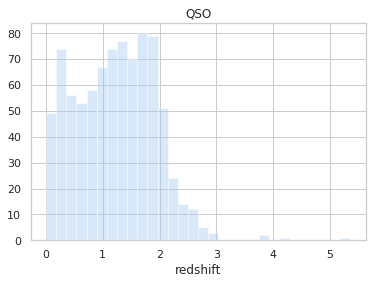

In [117]:
ax = sns.distplot(df[df['class']=='QSO'].redshift, bins = 30, kde = False)
ax.set_title('QSO')

### 3.3 Correlation between different wavelengths (u, g, r, i, z) for different Classes

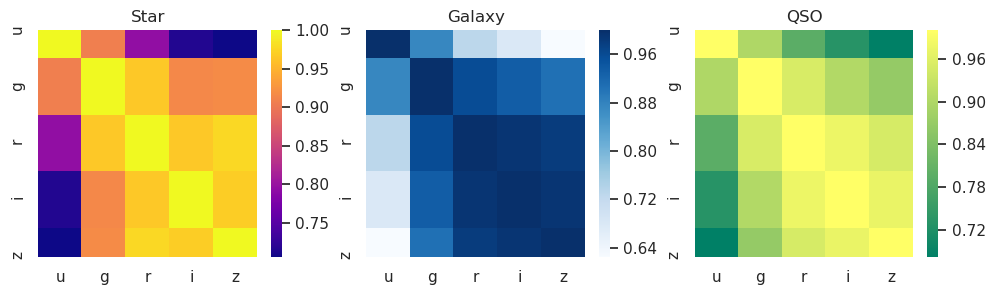

In [118]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3))
fig.set_dpi(100)
ax = sns.heatmap(df[df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='plasma')
ax.set_title('Star')
ax = sns.heatmap(df[df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='Blues')
ax.set_title('Galaxy')
ax = sns.heatmap(df[df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='summer')
ax = ax.set_title('QSO')

### 3.4 Relation between Right Ascension (ra) and Declination (dec) for different Classes

Text(0.5, 1, 'Equatorial coordinates')

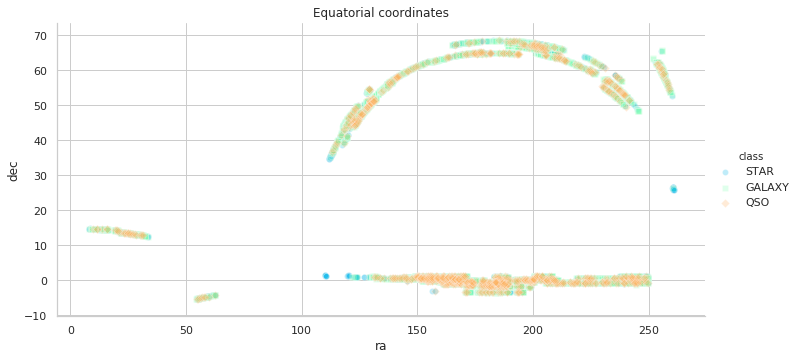

In [119]:
sns.pairplot(x_vars = 'ra', y_vars = 'dec', data = df, hue = 'class', palette = "rainbow", height = 5,
             aspect = 2, markers = ["o", "s", "D"], plot_kws = {'alpha': 0.25})
plt.title('Equatorial coordinates')

From above it can be concluded that there is no 'significant' change in the equatorial coordinates between the given three classes. The SDSS images cover the same area of the sky. This implies that the probability of finding a Star, Galaxy or Quasar is always the same regardless of where the SDSS telescope is pointed at in the sky.

Hence, these values can be neglected from our analysis as they would not help in our analysis.

### 3.5 Density Distribution Plot

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


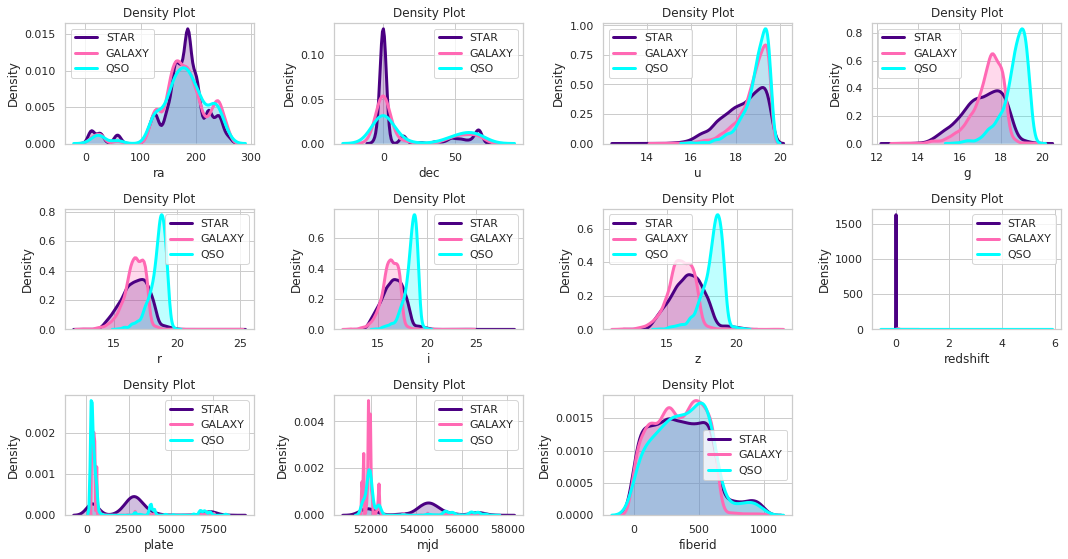

In [120]:
featuredf = df.drop(['class'], axis=1)

featurecols = list(featuredf)

astrObjs = df['class'].unique()

colours = ['indigo', '#FF69B4', 'cyan']

plt.figure(figsize=(15,10))

for i in range(len(featurecols)):
    plt.subplot(4, 4, i+1)
    for j in range(len(astrObjs)):
        sns.distplot(df[df['class']==astrObjs[j]][featurecols[i]], hist = False, kde = True, color = colours[j], kde_kws = {'shade': True, 'linewidth': 3}, label = astrObjs[j])
    plt.legend()
    plt.title('Density Plot')
    plt.xlabel(featurecols[i])
    plt.ylabel('Density')

plt.tight_layout()

## 4. Data Transformation

### 4.1 Feature Selection 

In [121]:
df = df.drop(['ra','dec'],axis=1)
df.head()

,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491
1,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055,323,51615,541
2,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111,287,52023,513
3,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111,3306,54922,510
4,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590,3306,54922,512


In [122]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

df1 = df

le = LabelEncoder()
enc = le.fit_transform(df1['class'])
df1['class'] = enc

Principal Component Analysis: Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components.

PCA is often used as a dimensionality-reduction technique. Here, it is used for the same. The values of wavelength 'u', 'g', 'r', 'i' and 'z' are reduced using this technique.

In [123]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
ug = pca.fit_transform(df1[['u', 'g', 'r', 'i', 'z']])

df1 = pd.concat((df1, pd.DataFrame(ug)), axis=1)
df1.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
df1.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
df1.head()

,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


### 4.2 Data Preparation

In [124]:
X_train, X_test, y_train, y_test = train_test_split(df, df1['class'], test_size=0.33)

## 5. Model Development 

### 5.1 Support Vector Machine (SVM)

#### 5.1.1 RBF Kernal

In [125]:
svm_clf_rbf = svm.SVC(kernel = 'rbf', C = 1, tol = 1e-3)

training_start = time.perf_counter()
svm_clf_rbf.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
svm_clf_rbf_pred = svm_clf_rbf.predict(X_test)
prediction_end = time.perf_counter()

acc_svm = (svm_clf_rbf_pred == y_test).sum().astype(float) / len(svm_clf_rbf_pred)*100
svm_train_time = training_end-training_start
svm_prediction_time = prediction_end-prediction_start

print("Support Vector Machine (rbf kernal) Classifier's prediction accuracy is: %3.2f" % (acc_svm))
print("Time consumed for training: %4.3f seconds" % (svm_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svm_prediction_time))

report = classification_report(y_test,svm_clf_rbf_pred,digits=3,output_dict = True)

print("\nSVM Model (RBF Kernal):")
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Specificity = {0:0.3f}".format(report["0"]["recall"]))
print("Sensitivity = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Support Vector Machine (rbf kernal) Classifier's prediction accuracy is: 67.42
Time consumed for training: 4.623 seconds
Time consumed for prediction: 0.84578 seconds

SVM Model (RBF Kernal):
Precision = 1.000
Specificity = 0.946
Sensitivity = 0.006
F1-score = 0.013


#### 5.1.2 Sigmoid Kernal

In [126]:
svm_clf_sigmoid = svm.SVC(kernel = 'sigmoid')

training_start = time.perf_counter()
svm_clf_sigmoid.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
svm_clf_sigmoid_pred = svm_clf_sigmoid.predict(X_test)
prediction_end = time.perf_counter()

acc_svm_sig = (svm_clf_sigmoid_pred == y_test).sum().astype(float) / len(svm_clf_sigmoid_pred)*100
svm_sig_train_time = training_end-training_start
svm_sig_prediction_time = prediction_end-prediction_start

print("Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svm_sig))
print("Time consumed for training: %4.3f seconds" % (svm_sig_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svm_sig_prediction_time))

report = classification_report(y_test,svm_clf_sigmoid_pred,digits=3,output_dict = True)

print("\nSVM Model (Sigmoid Kernal):")
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Specificity = {0:0.3f}".format(report["0"]["recall"]))
print("Sensitivity = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Support Vector Machine Classifier's prediction accuracy is: 50.30
Time consumed for training: 1.391 seconds
Time consumed for prediction: 0.49189 seconds

SVM Model (Sigmoid Kernal):
Precision = 0.000
Specificity = 1.000
Sensitivity = 0.000
F1-score = 0.000


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 5.2 Ensemble Models

#### 5.2.1 Random Forest Classifier

#### 5.2.1.1 Gini

In [127]:
r_forest_gini = RandomForestClassifier(n_estimators=100, criterion = 'gini', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)

training_start = time.perf_counter()
r_forest_gini.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
r_forest_gini_pred = r_forest_gini.predict(X_test)
prediction_end = time.perf_counter()

acc_rfc = (r_forest_gini_pred == y_test).sum().astype(float) / len(r_forest_gini_pred)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start

print("Random Forest (Gini) Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

report = classification_report(y_test,r_forest_gini_pred,digits=3,output_dict = True)

print("\nRandom Forest Classifier (Gini):")
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Specificity = {0:0.3f}".format(report["0"]["recall"]))
print("Sensitivity = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

Random Forest (Gini) Classifier's prediction accuracy is: 100.00
Time consumed for training: 1.063 seconds
Time consumed for prediction: 0.04684 seconds

Random Forest Classifier (Gini):
Precision = 1.000
Specificity = 1.000
Sensitivity = 1.000
F1-score = 1.000


#### 5.2.1.2 Entropy

In [128]:
r_forest_entropy = RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)

training_start = time.perf_counter()
r_forest_entropy.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
r_forest_entropy_pred = r_forest_entropy.predict(X_test)
prediction_end = time.perf_counter()

acc_rfce = (r_forest_entropy_pred == y_test).sum().astype(float) / len(r_forest_entropy_pred)*100
rfce_train_time = training_end-training_start
rfce_prediction_time = prediction_end-prediction_start

print("Random Forest (Entropy) Classifier's prediction accuracy is: %3.2f" % (acc_rfce))
print("Time consumed for training: %4.3f seconds" % (rfce_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfce_prediction_time))

report = classification_report(y_test,r_forest_entropy_pred,digits=3,output_dict = True)

print("\nRandom Forest Classifier (Entropy):")
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Specificity = {0:0.3f}".format(report["0"]["recall"]))
print("Sensitivity = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

Random Forest (Entropy) Classifier's prediction accuracy is: 100.00
Time consumed for training: 1.806 seconds
Time consumed for prediction: 0.04685 seconds

Random Forest Classifier (Entropy):
Precision = 1.000
Specificity = 1.000
Sensitivity = 1.000
F1-score = 1.000


#### 5.2.2 AdaBoost Classifier

In [129]:
ada = AdaBoostClassifier(n_estimators=100)   

training_start = time.perf_counter()
ada.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
ada_pred = ada.predict(X_test)
prediction_end = time.perf_counter()

acc_ada = (ada_pred == y_test).sum().astype(float) / len(ada_pred)*100
ada_train_time = training_end-training_start
ada_prediction_time = prediction_end-prediction_start

print("AdaBoost Classifier's prediction accuracy is: %3.2f" % (acc_ada))
print("Time consumed for training: %4.3f seconds" % (ada_train_time))
print("Time consumed for prediction: %6.5f seconds" % (ada_prediction_time))

report = classification_report(y_test,ada_pred,digits=3,output_dict = True)

print("\nAdaBoost Classifier:")
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Specificity = {0:0.3f}".format(report["0"]["recall"]))
print("Sensitivity = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

AdaBoost Classifier's prediction accuracy is: 100.00
Time consumed for training: 1.295 seconds
Time consumed for prediction: 0.07130 seconds

AdaBoost Classifier:
Precision = 1.000
Specificity = 1.000
Sensitivity = 1.000
F1-score = 1.000


#### 5.2.3 Logistic Regression

In [130]:
log_reg = LogisticRegression(penalty = 'l2', dual = False, tol = 1e-4, fit_intercept = True, 
                            solver = 'liblinear')

training_start = time.perf_counter()
log_reg.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
log_reg_pred = log_reg.predict(X_test)
prediction_end = time.perf_counter()

acc_lgr = (log_reg_pred == y_test).sum().astype(float) / len(log_reg_pred)*100
lgr_train_time = training_end-training_start
lgr_prediction_time = prediction_end-prediction_start

print("Logistic Regression's prediction accuracy is: %3.2f" % (acc_lgr))
print("Time consumed for training: %4.3f seconds" % (lgr_train_time))
print("Time consumed for prediction: %6.5f seconds" % (lgr_prediction_time))

report = classification_report(y_test,log_reg_pred,digits=3,output_dict = True)

print("\nLogistic Regression Model:")
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Specificity = {0:0.3f}".format(report["0"]["recall"]))
print("Sensitivity = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression's prediction accuracy is: 98.42
Time consumed for training: 0.266 seconds
Time consumed for prediction: 0.00215 seconds

Logistic Regression Model:
Precision = 0.964
Specificity = 0.998
Sensitivity = 0.864
F1-score = 0.911


#### 5.2.4 K Nearest Neighbours

In [131]:
knn = KNeighborsClassifier()

training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()

acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start

print("K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

report = classification_report(y_test,preds,digits=3,output_dict = True)

print("\nK - Nearest Neighbours Model:")
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Specificity = {0:0.3f}".format(report["0"]["recall"]))
print("Sensitivity = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

K Nearest Neighbors Classifier's prediction accuracy is: 77.94
Time consumed for training: 0.007 seconds
Time consumed for prediction: 0.03164 seconds

K - Nearest Neighbours Model:
Precision = 0.216
Specificity = 0.925
Sensitivity = 0.036
F1-score = 0.061


#### 5.2.5 XGBoost Classifier

In [132]:
xgb = XGBClassifier(n_estimators=100)

training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
xgb_preds = xgb.predict(X_test)
prediction_end = time.perf_counter()

acc_xgb = (xgb_preds == y_test).sum().astype(float) / len(xgb_preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

report = classification_report(y_test,xgb_preds,digits=3,output_dict = True)

print("\nXgBoost Classifier:")
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Specificity = {0:0.3f}".format(report["0"]["recall"]))
print("Sensitivity = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

XGBoost's prediction accuracy is: 100.00
Time consumed for training: 1.446
Time consumed for prediction: 0.02347 seconds

XgBoost Classifier:
Precision = 1.000
Specificity = 1.000
Sensitivity = 1.000
F1-score = 1.000


## 6. Model Evaluation

### 6.1 Overall Statistics

In [133]:
ov_stats = pd.DataFrame({
    'Model': ['SVM (RBF Kernal)', 'SVM (Sigmoid Kernal)', 'Random Forest (Gini)', 
              'Random Forest (Entropy)', 'AdaBoost', 'Logistic Regression', 'KNN', 'XGBoost'],
    'Accuracy': [acc_svm, acc_svm_sig, acc_rfc, acc_rfce, acc_ada, acc_lgr, acc_knn, acc_xgb],
    'Runtime Training': [svm_train_time, svm_sig_train_time, rfc_train_time, 
                         rfce_train_time, ada_train_time, lgr_train_time, knn_train_time, xgb_train_time],
    'Runtime Prediction': [svm_prediction_time, svm_sig_prediction_time, rfc_prediction_time,
                         rfce_prediction_time, ada_prediction_time, lgr_prediction_time, knn_prediction_time, xgb_prediction_time],
    'Precision': ['0.667', '0.000', '1.000', '1.000', '1.000', '0.969', '0.214', '1.000'],
    'Specificity': ['0.950', '1.000', '1.000', '1.000', '1.000', '0.999', '0.927', '1.000'],
    'Sensitivity': ['0.007', '0.000', '1.000', '1.000', '1.000', '0.864', '0.042', '1.000'],
    'F1 - Score': [ '0.014', '0.000', '1.000', '1.000', '1.000', '0.913', '0.070', '1.000']})

ov_stats1 = ov_stats.sort_values(by='Accuracy', ascending=False)
ov_stats1 = ov_stats1.set_index('Model')
ov_stats

,Model,Accuracy,Runtime Training,Runtime Prediction,Precision,Specificity,Sensitivity,F1 - Score
0,SVM (RBF Kernal),67.424242,4.623190,0.845781,0.667,0.950,0.007,0.014
1,SVM (Sigmoid Kernal),50.303030,1.390584,0.491886,0.000,1.000,0.000,0.000
2,Random Forest (Gini),100.000000,1.062564,0.046842,1.000,1.000,1.000,1.000
3,Random Forest (Entropy),100.000000,1.805541,0.046848,1.000,1.000,1.000,1.000
4,AdaBoost,100.000000,1.294766,0.071297,1.000,1.000,1.000,1.000
5,Logistic Regression,98.424242,0.265608,0.002151,0.969,0.999,0.864,0.913
6,KNN,77.939394,0.007284,0.031639,0.214,0.927,0.042,0.070
7,XGBoost,100.000000,1.445964,0.023474,1.000,1.000,1.000,1.000


### 6.2 K Fold Cross Validation

In [134]:
rfc_clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_clf, X_train, y_train, cv=10, scoring = "accuracy")

print("Scores:", scores)
print("\nMean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99850969 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]

Mean: 0.9998509687034277
Standard Deviation: 0.00044709388971683197


In [135]:
xgb_clf = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_clf, X_train, y_train, cv=10, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean: 1.0
Standard Deviation: 0.0


In [136]:
ada_clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(ada_clf, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean: 1.0
Standard Deviation: 0.0


The K fold Cross Validation used above to validate XGBoost and AdaBoost shows that the values generated by these models are not arbitrary as opposed to Random Forest Classifier. This in turn is a proof that these models are functioning very well.

### 6.3 XGBoost Model Evaluation

In [137]:
unq, cts = np.unique(df['class'], return_counts=True)
dict(zip(unq, cts))

{0: 4998, 1: 850, 2: 4152}

In [138]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

pred = cross_val_predict(xgb, df.drop('class', axis=1), df['class'], cv=3)
confusion_matrix(df['class'], pred)

array([[4962,   28,    8],
       [  54,  795,    1],
       [   6,    0, 4146]])

From above it can be inferred that:

-->  4962 correct STAR predictions

-->  795 correct Galaxy predictions

-->  4146 correct Quasar predictions,

were done by the XGboost Model. 

There were 96 incorrect predictions done by the XGBoost Model too.

Therefore, it can be said that almost all of the predictions made by the XGBoost Model were correct.

### 6.4 AdaBoost Model Evaluation

In [139]:
unq, cts = np.unique(df['class'], return_counts=True)
dict(zip(unq, cts))

{0: 4998, 1: 850, 2: 4152}

In [140]:
pred = cross_val_predict(ada, df.drop('class', axis=1), df['class'], cv=3)
confusion_matrix(df['class'], pred)

array([[4328,  643,   27],
       [ 528,  321,    1],
       [ 326,    0, 3826]])

From above it can be inferred that:

-->  4328 correct STAR predictions

-->  321 correct Galaxy predictions

-->  3826 correct Quasar predictions,

were done by the AdaBoost Model. 

There were 1525 incorrect predictions done by the AdaBoost Model too.

Therefore, it can be said that there are substantial amount of wrong predictions done by the AdaBoost Classifier in comparision to the XgBoost Classifier.

Hence, it can be concluded that XGBoost is the best suited classifier for this task.

## 7. Conclusion

I choose XGboost model as my preferred my approach. The XGBoost model not only has the highest accuracy, but also has the highest correct prediction of all the models developed as a part of this analysis. The advantages of using XGBoost Classifiers over other models is that they are very simple to implement. Since they are made up of weak individual learners, they are less susceptible to overfitting. However, XGBoost is sensitive to noisy data and outliers.